In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, color, exposure
import skimage

from pathlib import Path
import os, sys

from dask import bag, diagnostics


sys.path.insert(0, str(Path.cwd().parent))
import leukopy_lib as leuko
from importlib import reload
reload(leuko)

<module 'leukopy_lib' from '/home/marie-anne/code/Leukopy/notebooks/leukopy_lib.py'>

## Import normal peripheral blood cell dataset

In [2]:
path_name = '../../data/PBC_dataset_normal_df.csv'
path = Path(path_name)
df = pd.read_csv(path_name)
df.head()

img_paths      id label  height  \
0  ../../data/PBC_dataset_normal_DIB/monocyte/MO_...  225079    MO     363   
1  ../../data/PBC_dataset_normal_DIB/monocyte/MO_...  582430    MO     363   
2  ../../data/PBC_dataset_normal_DIB/monocyte/MO_...  436409    MO     363   
3  ../../data/PBC_dataset_normal_DIB/monocyte/MO_...  648815    MO     363   
4  ../../data/PBC_dataset_normal_DIB/monocyte/MO_...  668574    MO     363   

   width  mean_brightness  
0    360       196.225564  
1    360       196.672727  
2    360       204.348235  
3    360       199.038259  
4    360       191.020018

In [3]:
#We now have 8 classes
classes = df['label'].unique()
classes

array(['MO', 'ERB', 'PLATELET', 'BA', 'IG', 'SNE', 'LY', 'EO'],
      dtype=object)

### Import images and store as a array of arrays

In [4]:
#to load images if need but huge in memory
# dfile_bag = bag.from_sequence(df.img_paths.to_list()).map(leuko.load_image, rescale= (0.5, 0.5, 1))
# with diagnostics.ProgressBar():
#     images = np.array(dfile_bag.compute())

# print(pd.Series([im.shape for im in images]).unique())
# print(images.shape)

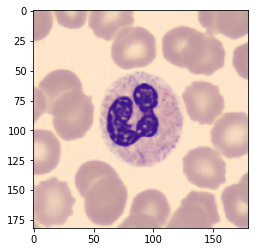

In [5]:
i = np.random.randint(0,len(df))
plt.imshow(leuko.load_image(df.img_paths[i], rescale= (0.5, 0.5, 1)))

## Deconvolution

In [8]:
def plot_deconv_single(idx, methods=color.bpx_from_rgb):
    
    im = leuko.load_image(df.img_paths[idx])
    lab = df.loc[idx]['label']
    deconv = color.separate_stains(im, method)

    fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15, 15))
    ax[0, 0].imshow(deconv[..., 0], cmap='Purples')
    ax[0, 0].set_title(f'{idx} - {lab}', fontweight='bold')
    hist, hist_centers = exposure.histogram(deconv[..., 0])
    ax[0, 1].plot(hist_centers, hist, lw=2, c='mediumpurple')
    ax[0, 1].set_title('channel 1')
    ax[0, 1].set_xlim(-0.1, 0.1)

    ax[1, 0].imshow(deconv[..., 1], cmap='pink_r')
    hist, hist_centers = exposure.histogram(deconv[..., 1])
    ax[1, 1].plot(hist_centers, hist, lw=2, c='gold')
    ax[1, 1].set_title('channel 2')
    ax[1, 1].set_xlim(-0.1, 0.1)

    
    ax[2, 0].imshow(deconv[..., 2], cmap='RdPu_r')
    hist, hist_centers = exposure.histogram(deconv[..., 2])
    ax[2, 1].plot(hist_centers, hist, lw=2, c='deeppink')
    ax[2, 1].set_title('channel 3')
    ax[2, 1].set_xlim(-0.1, 0.1)
    
    plt.show()

    return deconv, fig

In [9]:
methods = [color.bex_from_rgb, color.bpx_from_rgb, color.bro_from_rgb, 
           #color.gdx_from_rgb, color.hax_from_rgb, color.hdx_from_rgb, 
           color.hed_from_rgb, color.hpx_from_rgb, color.rbd_from_rgb]

1 9868


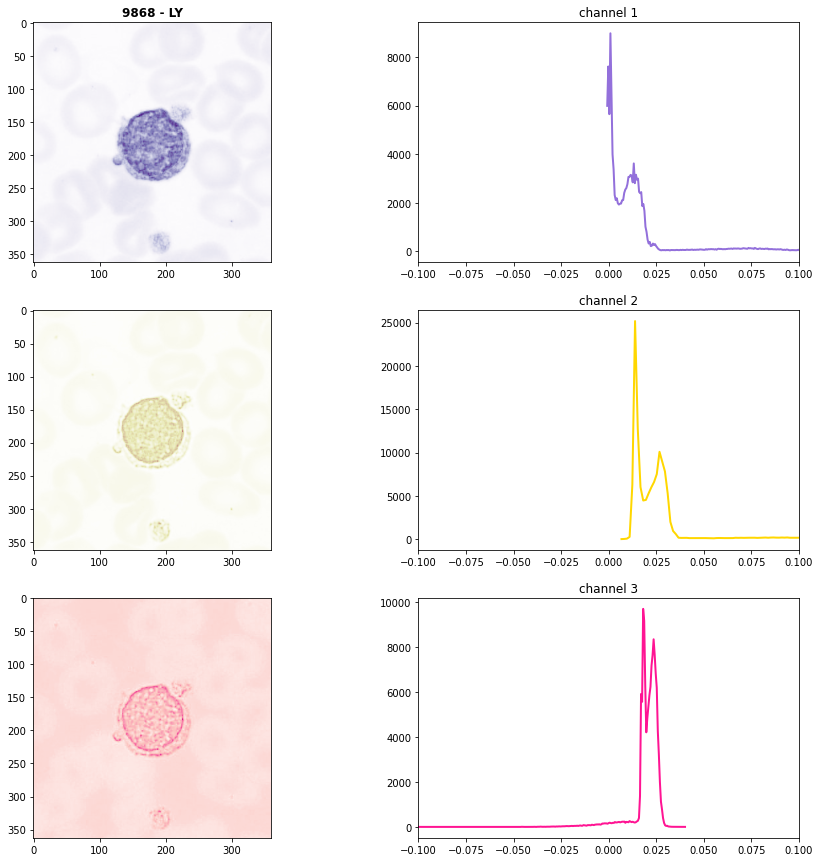

2 9868


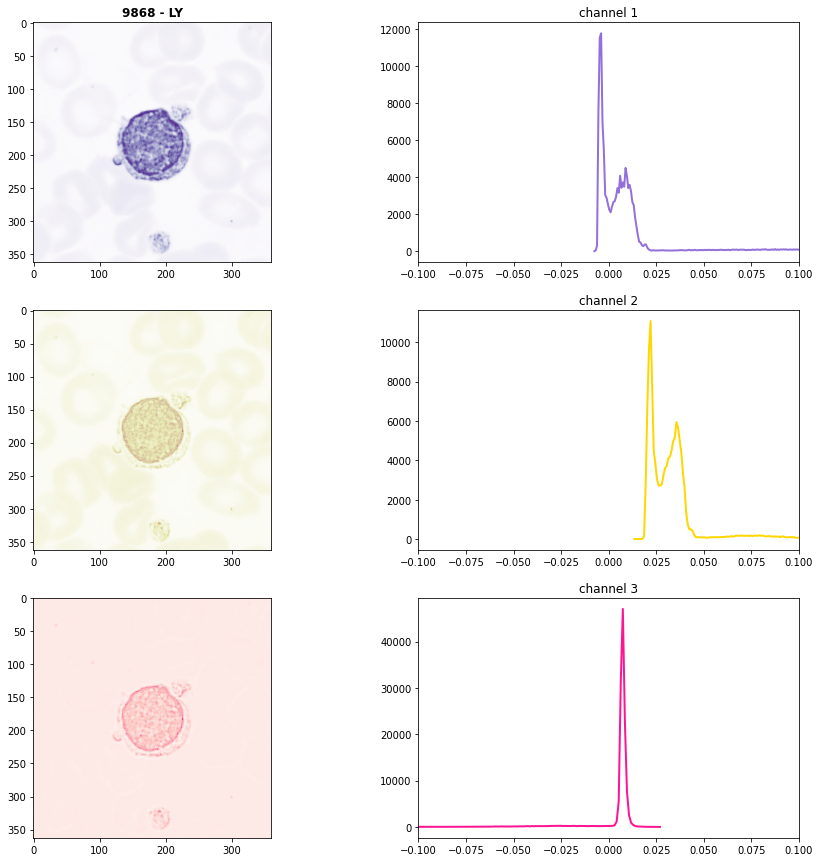

3 9868


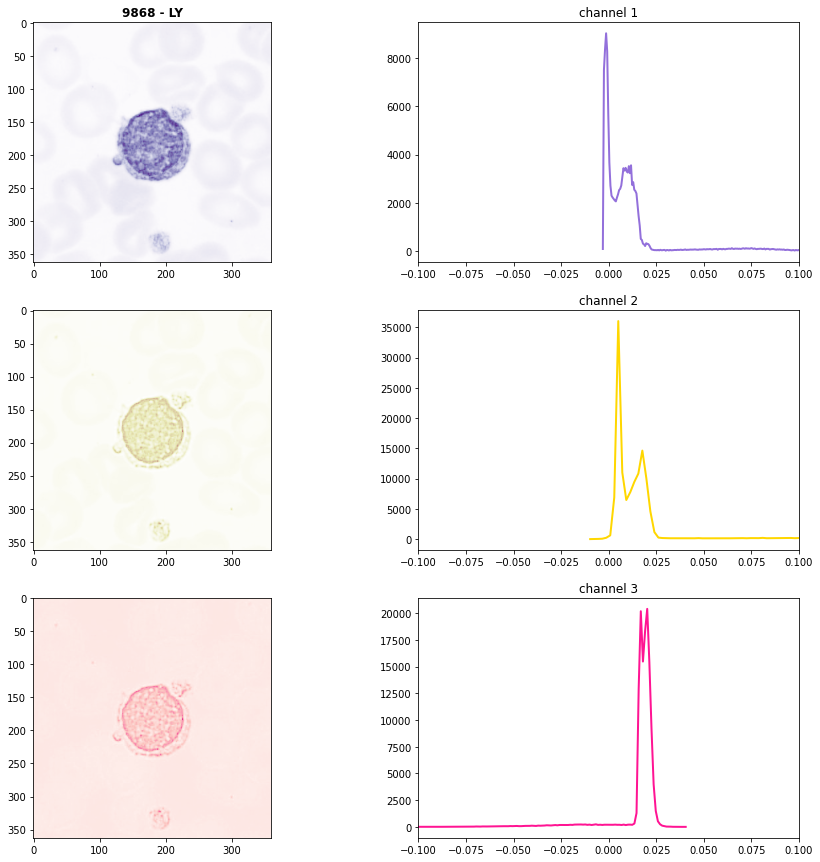

4 9868


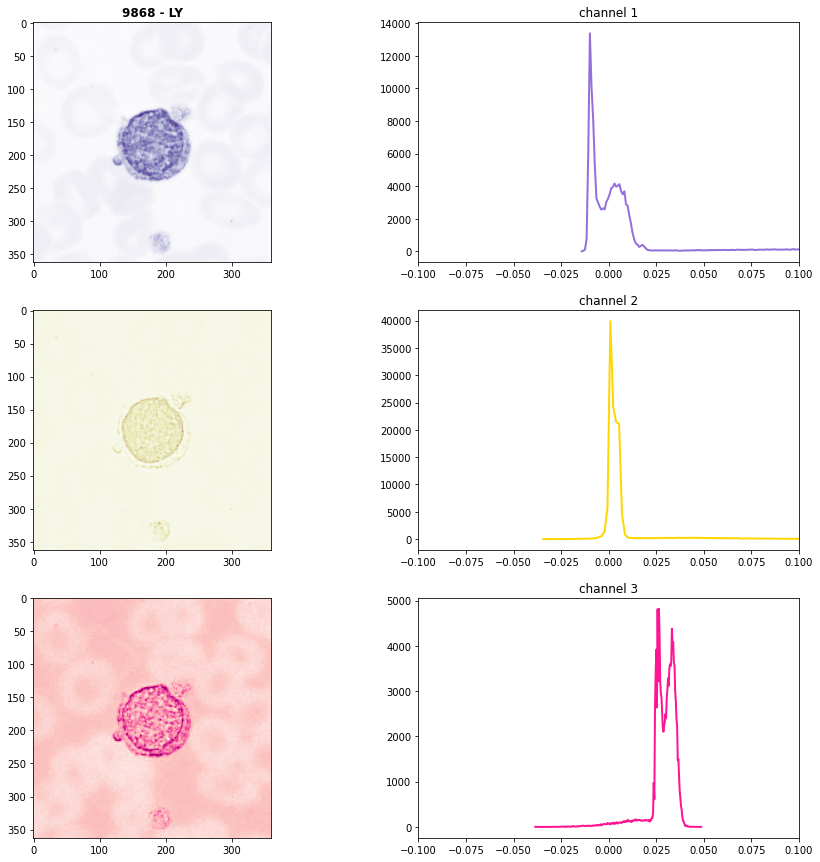

5 9868


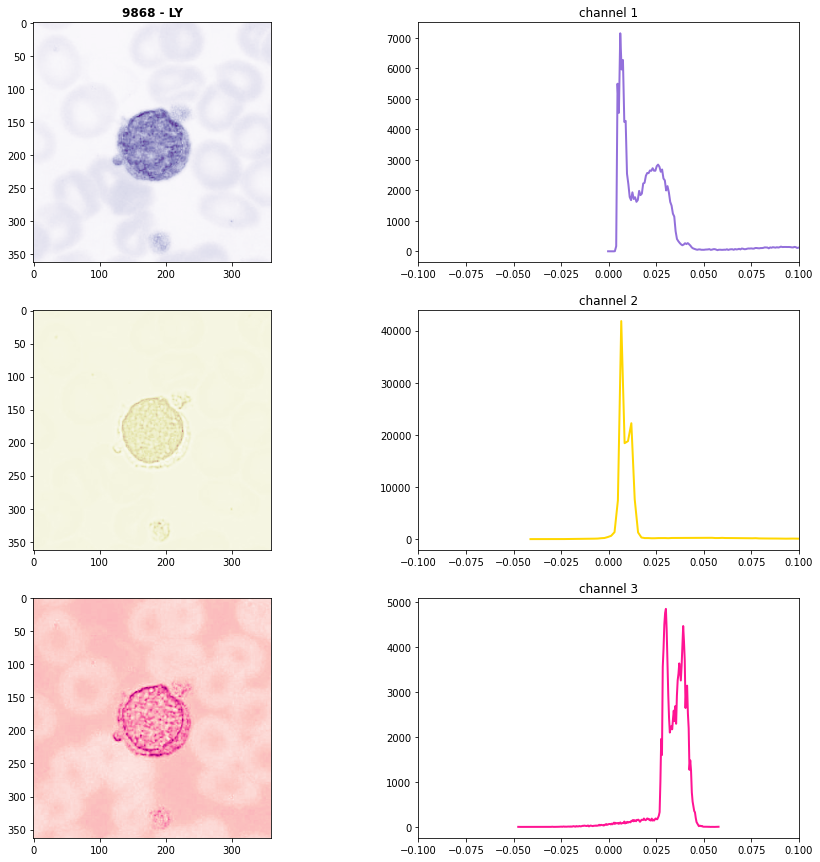

6 9868


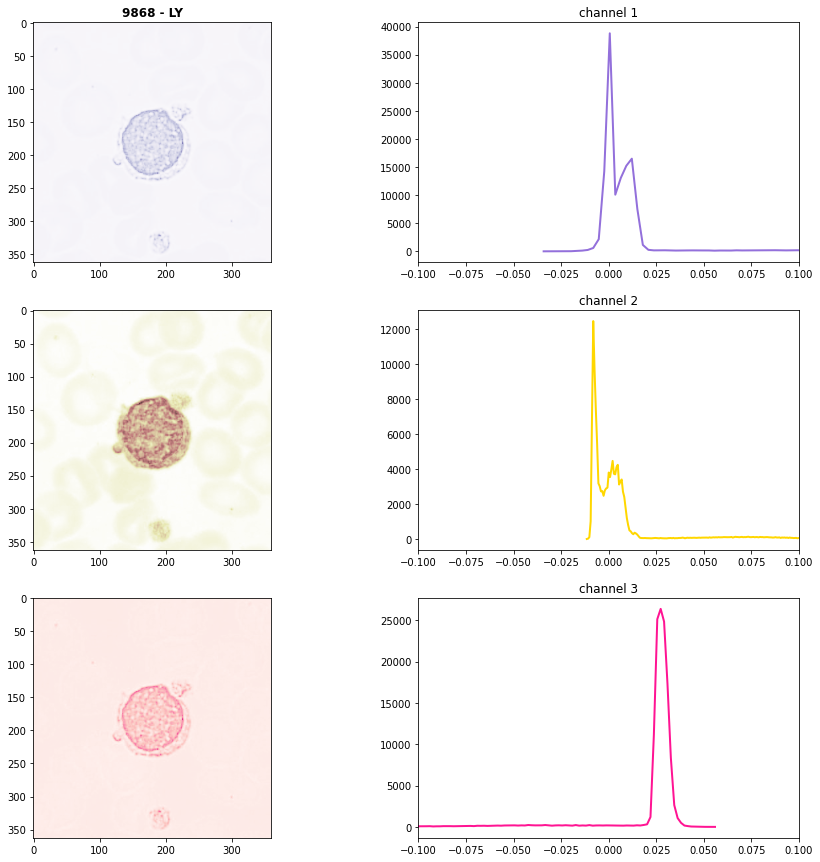

In [11]:
rand = np.random.choice(range(df.shape[0]))
for i, method in enumerate(methods):
    print(i+1, rand)
    plot_deconv_single(rand, method)

**The staining seems best deconvolved from the background with `bpx` (methyl blue + ponceau).**

### Let's compute the deconvolution with this method for all images

In [12]:
def deconvolution_hist(filename, method=color.bpx_from_rgb):
    
    im = leuko.load_image(filename)
    temp = pd.DataFrame(index=[0])


    deconv = color.separate_stains(im, method)

    temp[['mean_C1', 'mean_C2', 'mean_C3']] = [np.mean(deconv, axis=(0, 1))]
    temp[['std_C1', 'std_C2', 'std_C3']] = [np.std(deconv, axis=(0, 1))]
    temp['hist0'] = [exposure.histogram(deconv[..., 0])]
    temp['hist1'] = [exposure.histogram(deconv[..., 1])]
    temp['hist2'] = [exposure.histogram(deconv[..., 2])]

        
    return temp

In [13]:
deconv_bag = bag.from_sequence(df.img_paths.to_list()).map(deconvolution_hist)
with diagnostics.ProgressBar():
    res = deconv_bag.compute()

[########################################] | 100% Completed |  6min 41.0s


In [14]:
res_deconv = pd.concat(res)
res_deconv = res_deconv.reset_index(drop=True)

In [16]:
df_deconv = df.join(res_deconv)
df_deconv.to_csv(Path('../../data/PBS_dataset_normal_resize_deconv.csv'), index=False)

### Mean luminance per channel following deconvolution

In [18]:
def box_plot(col, df):
    plt.figure(figsize = (16,6))
    plt.subplot(1,2,1)
    sns.boxplot(x = "label", y = col, data = df)

    plt.subplot(1,2,2)
    sns.kdeplot(x = col, hue = "label", data = df)
    
    plt.show()

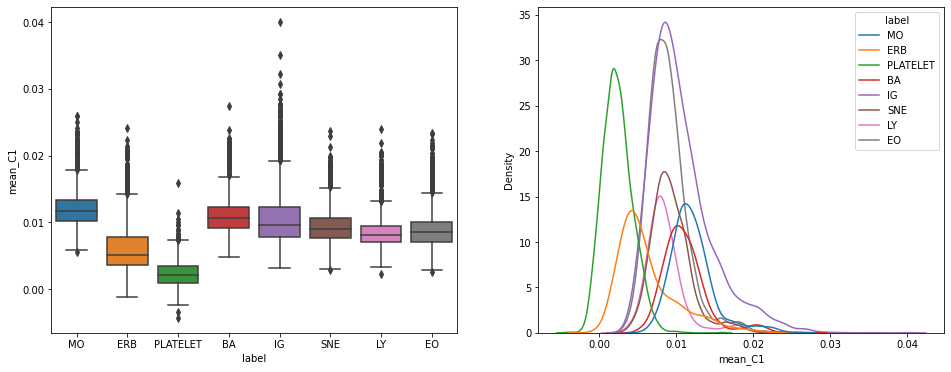

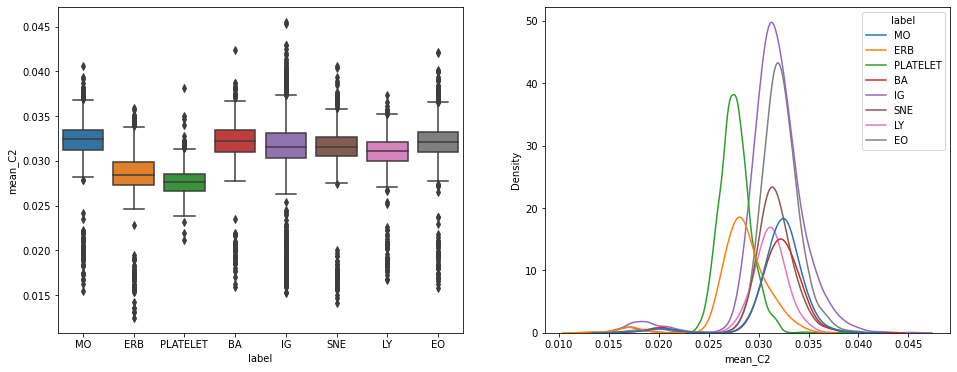

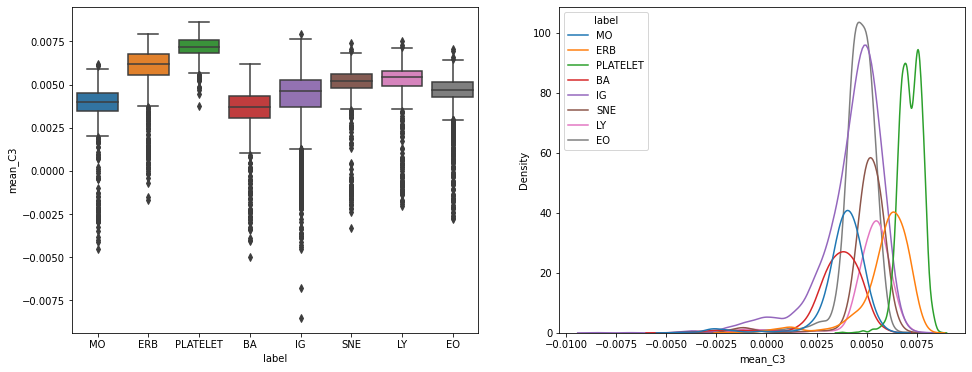

In [19]:
for col in ['mean_C1', 'mean_C2', 'mean_C3']:
    box_plot(col, df_deconv)


### Histogram analysis

In [ ]:
def plot_histogram(df, title):
    hist0 = np.array([*df['hist0']]).mean(axis=0)
    hist1 = np.array([*df['hist1']]).mean(axis=0)
    hist2 = np.array([*df['hist2']]).mean(axis=0)

    plt.plot(hist0[1], hist0[0], c='mediumpurple', label='C1 (nucleus)')
    plt.plot(hist1[1], hist1[0], c='gold', label='C2 (rbc)')
    plt.plot(hist2[1], hist2[0], c='deeppink', label='C3 (bkg)')

    plt.xlim(-0.1, 0.1)
    plt.title(f'Deconvolution level histogram for {title}')
    plt.legend()
    plt.show()

In [107]:
def plot_histgram_per_cell(df, label):
    
    temp_df =  df[df.label == label]
    
    plot_histogram(temp_df, label)
    

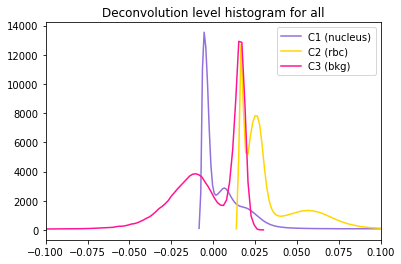

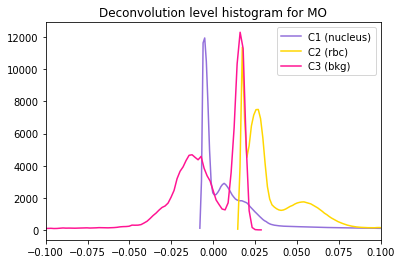

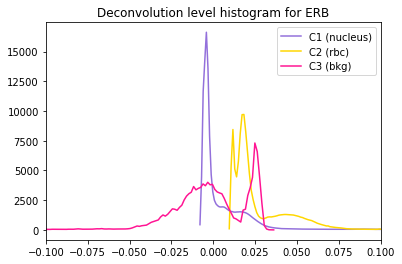

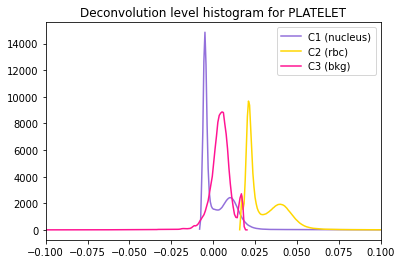

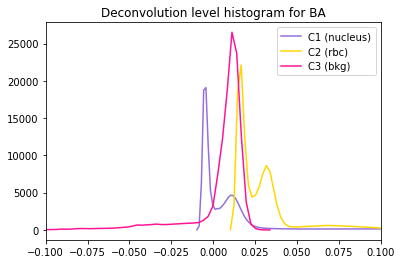

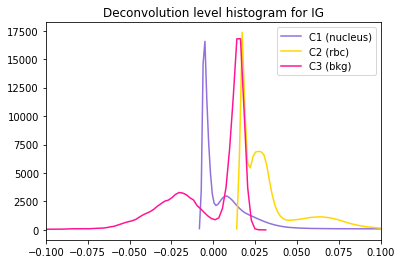

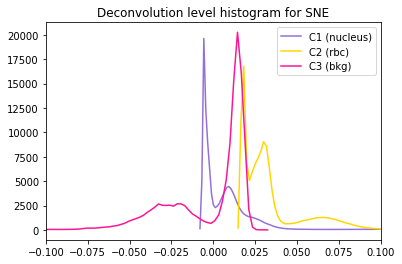

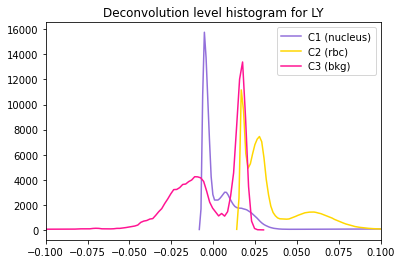

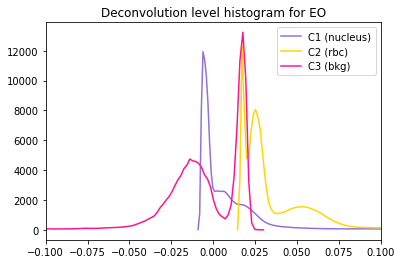

In [108]:
plot_histogram(df_deconv, 'all')

for cell in df.label.unique():
    plot_histgram_per_cell(df_deconv, cell)

## Plotting outliers found in gray value analysis


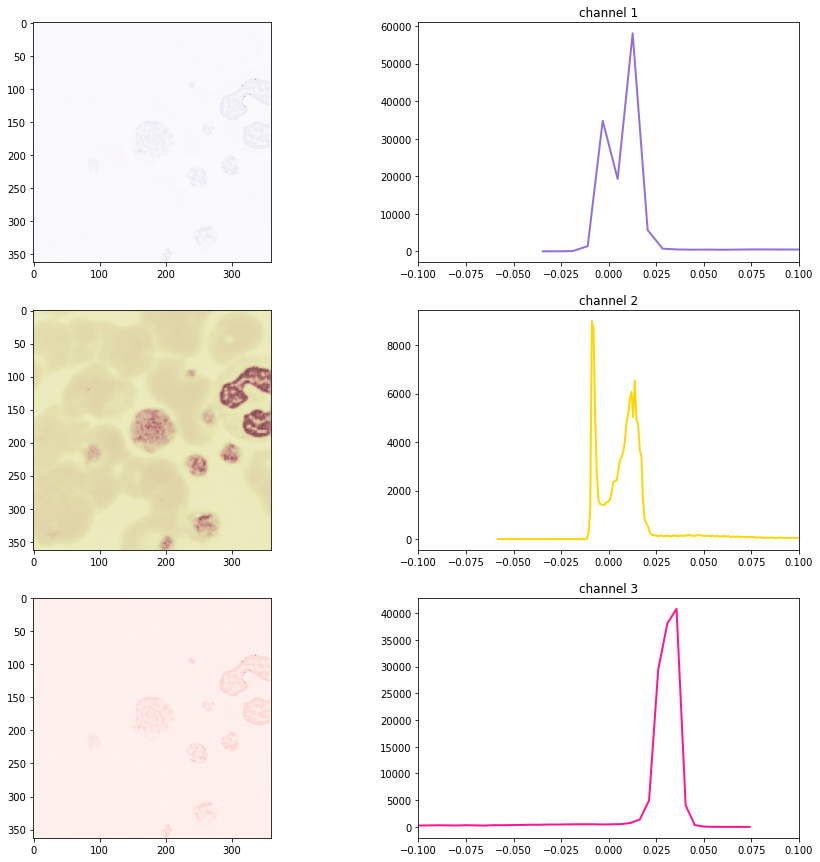

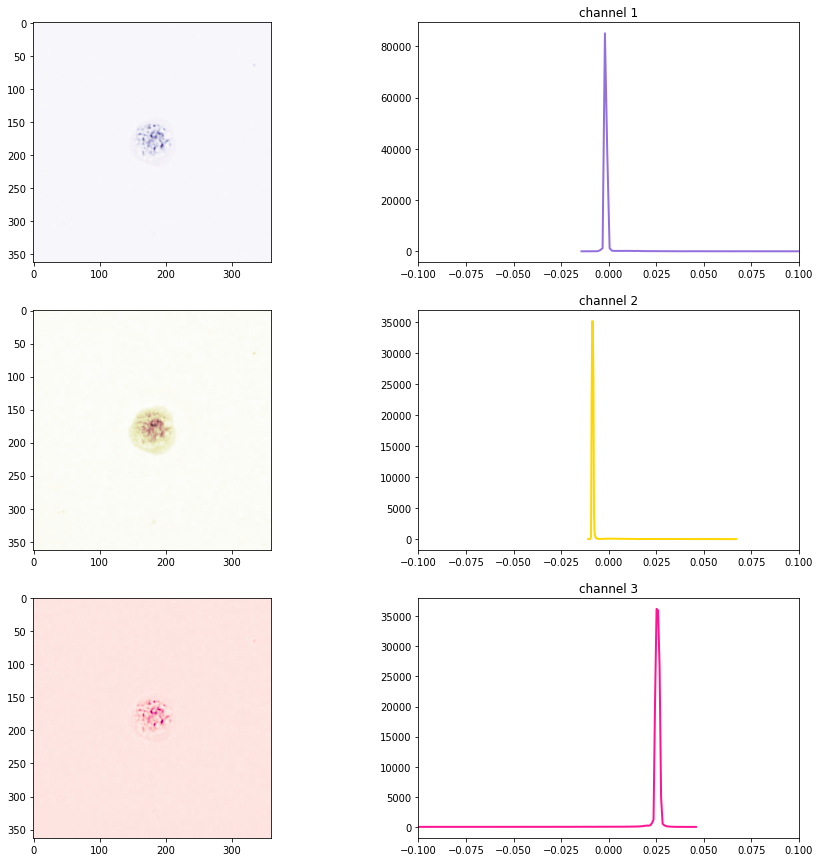

In [123]:
plot_deconv_single(4387)
plot_deconv_single(3680);

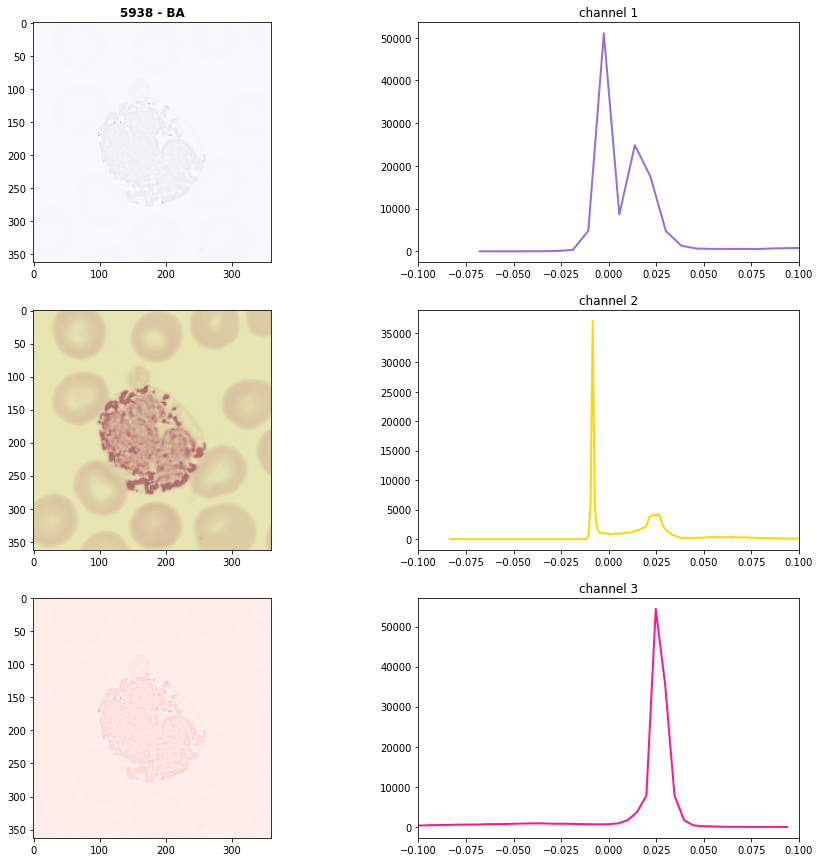

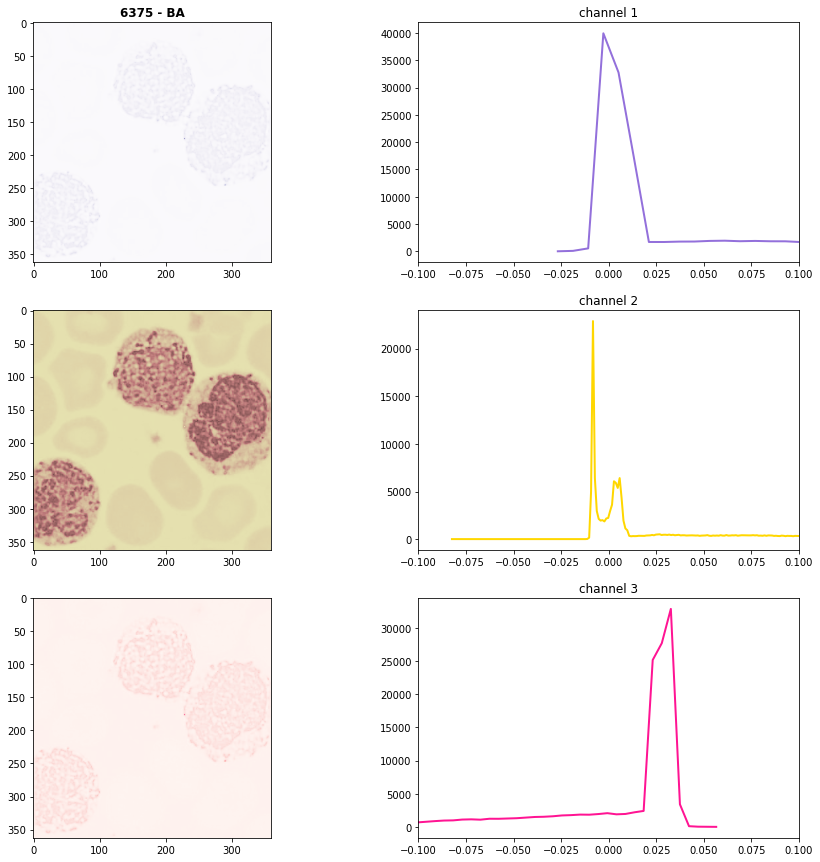

In [20]:
plot_deconv_single(5938)
plot_deconv_single(6375);

### Plot image with different background

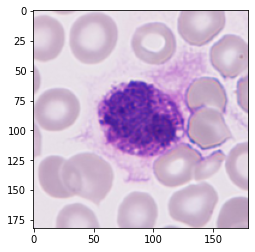

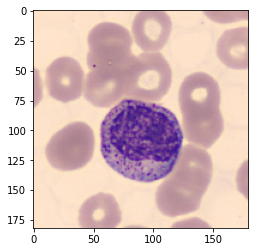

In [21]:
plt.imshow(leuko.load_image(df.img_paths[5889], rescale= (0.5, 0.5, 1)))
plt.show()
plt.imshow(leuko.load_image(df.img_paths[16362], rescale= (0.5, 0.5, 1)))


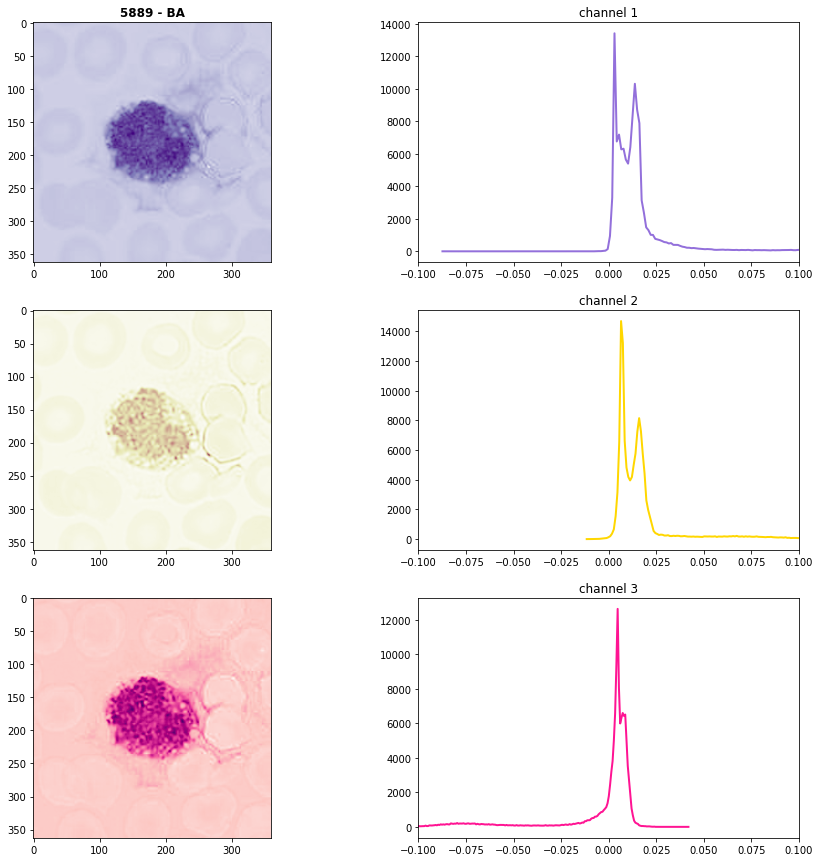

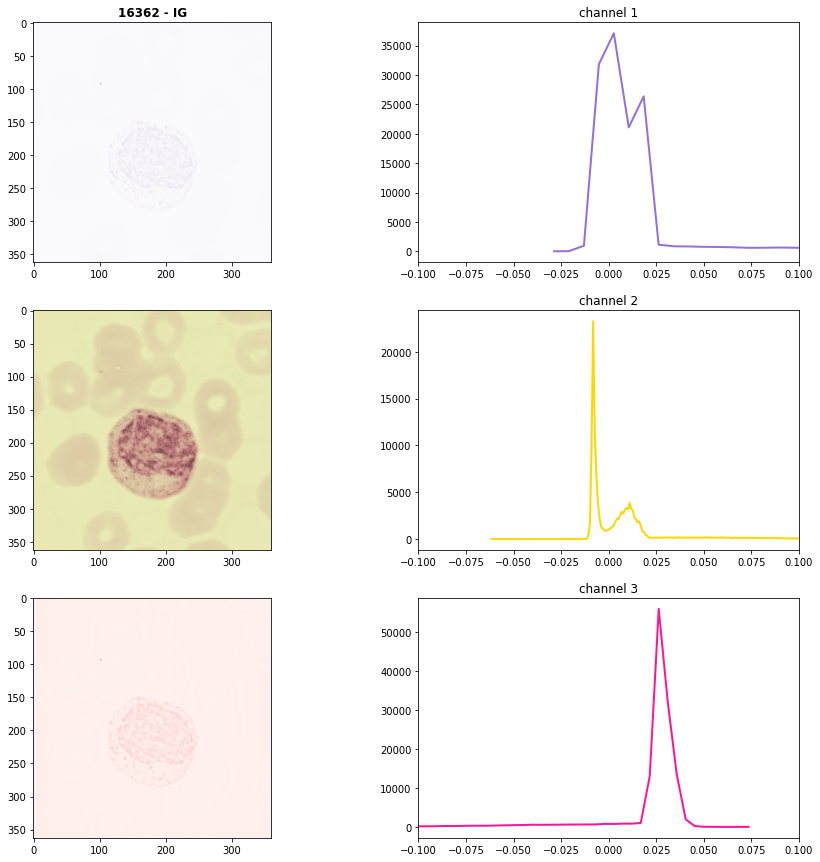

In [22]:
plot_deconv_single(5889)
plot_deconv_single(16362);

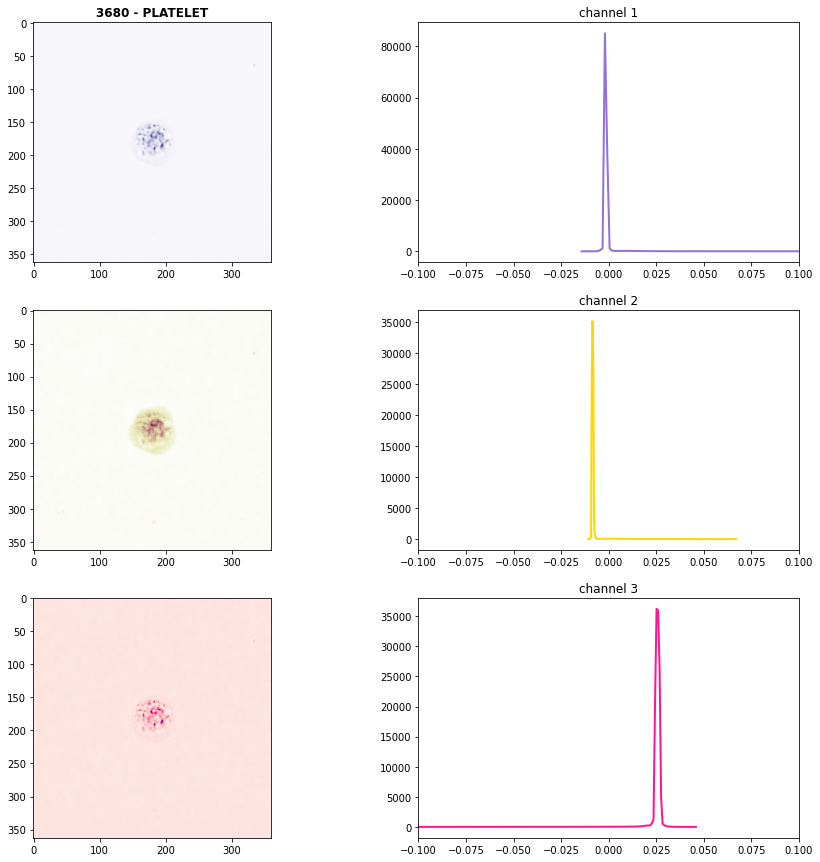

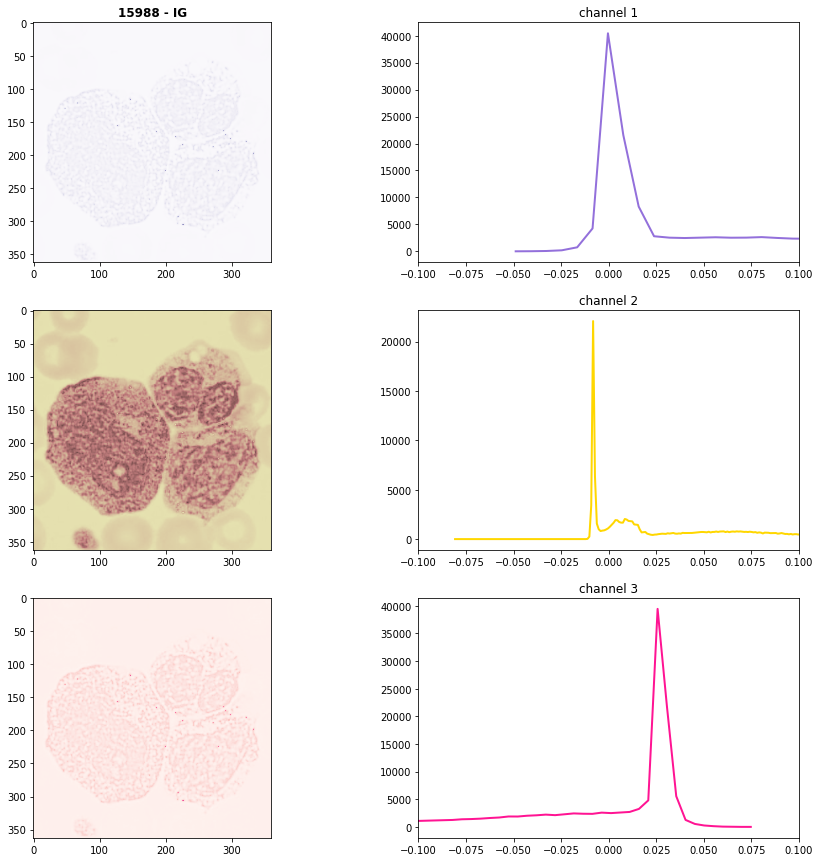

In [24]:
plot_deconv_single(df_deconv.mean_C1.argmin())
plot_deconv_single(df_deconv.mean_C1.argmax());


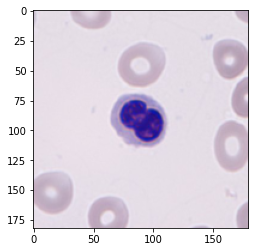

In [27]:
plt.imshow(leuko.load_image(df.img_paths[2472], rescale= (0.5, 0.5, 1)))


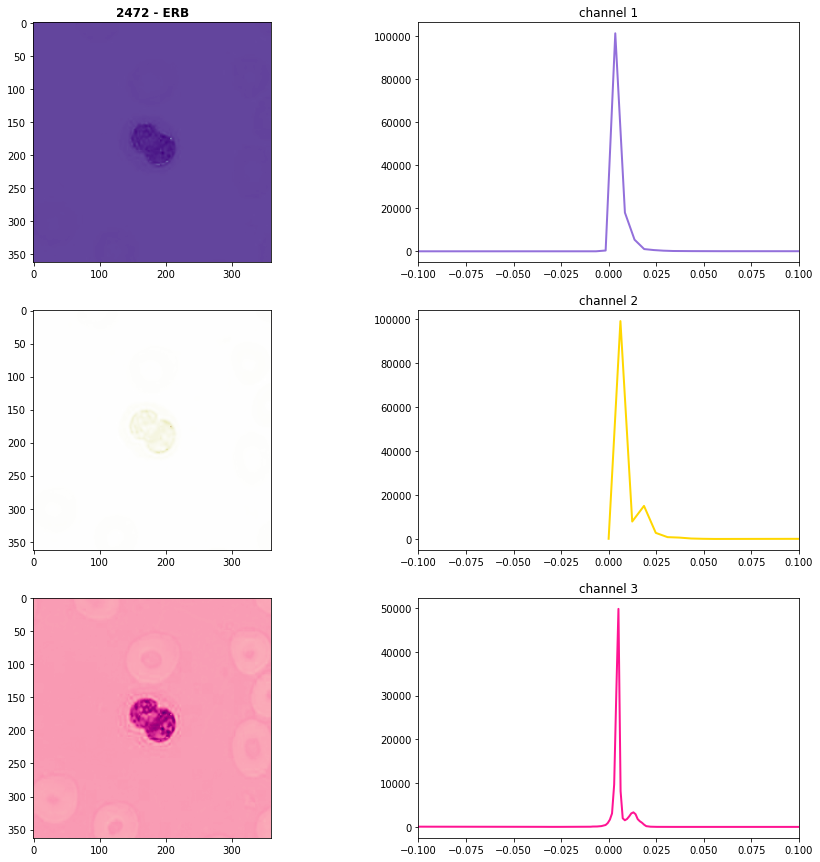

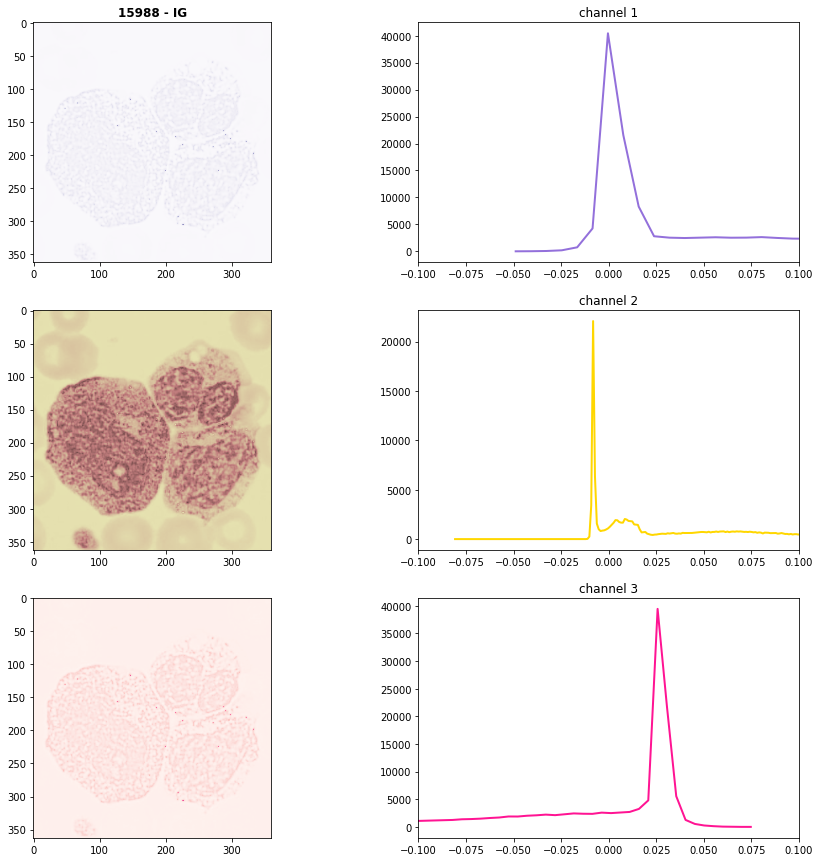

In [25]:
plot_deconv_single(df_deconv.mean_C2.argmin())
plot_deconv_single(df_deconv.mean_C2.argmax());

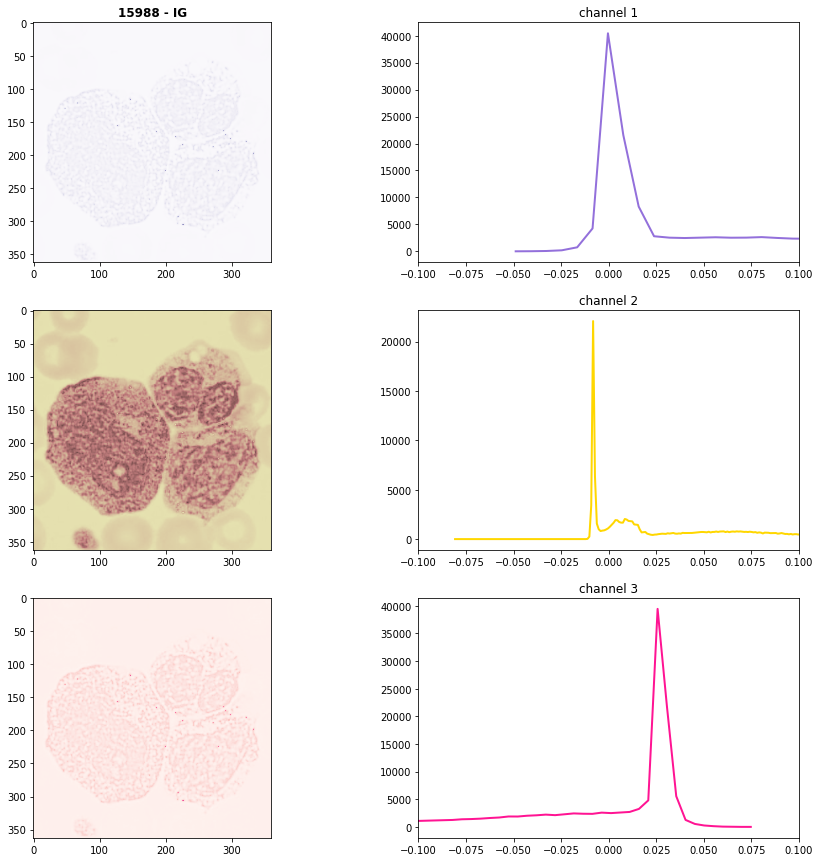

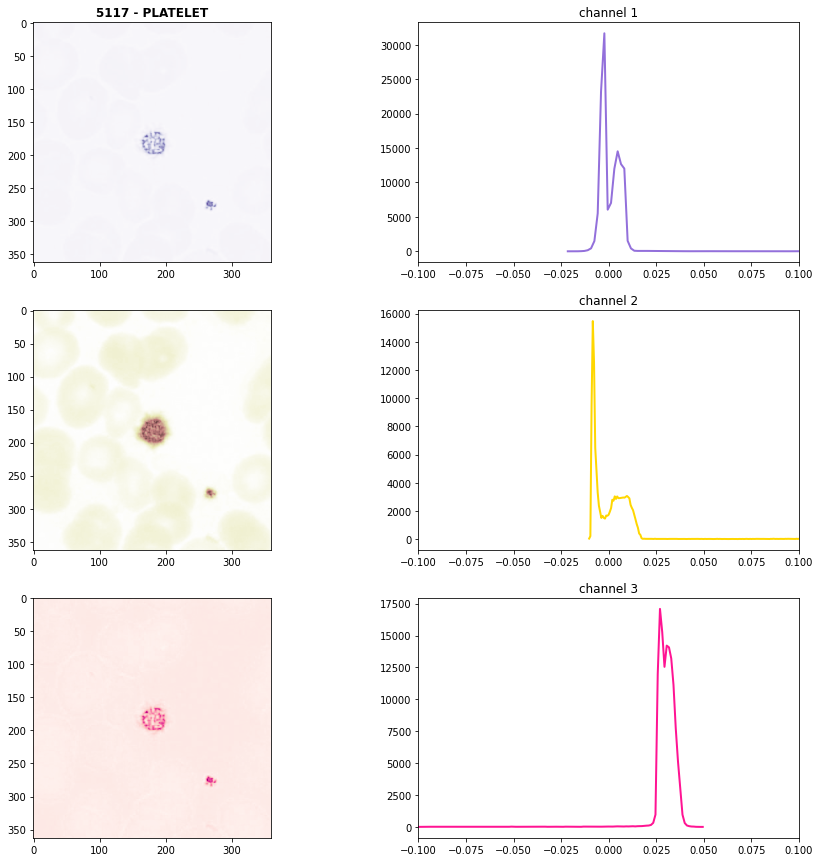

In [26]:
plot_deconv_single(df_deconv.mean_C3.argmin())
plot_deconv_single(df_deconv.mean_C3.argmax());